In [1]:
##%% IMPORTING LIBRARIES

import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
##%% IMPORTING DATA

def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        img = Image.open(filename,'r')
        IMG = np.array(img)
        sample.append(filename)
    return sample

path1 = 'C:/vansh/programming/project/python/archive/no/*.jpg'
path2 = 'C:/vansh/programming/project/python/archive/yes/*.jpg'
path3 = 'C:/vansh/programming/project/python/archive/pred/*.jpg'
path4 = 'C:/vansh/programming/project/python/archive/xyz/*.jpg'
train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)
xyz_test = importing_data(path4)

##%% CREATION OF DATASETS

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
xyz_test=pd.DataFrame({'image':xyz_test})
train_data = pd.concat([df_train_n, df_train_y])
train_data

,image,label
0,C:/vansh/programming/project/python/archive/no...,Healthy
1,C:/vansh/programming/project/python/archive/no...,Healthy
2,C:/vansh/programming/project/python/archive/no...,Healthy
3,C:/vansh/programming/project/python/archive/no...,Healthy
4,C:/vansh/programming/project/python/archive/no...,Healthy
...,...,...
1495,C:/vansh/programming/project/python/archive/ye...,Affected
1496,C:/vansh/programming/project/python/archive/ye...,Affected
1497,C:/vansh/programming/project/python/archive/ye...,Affected
1498,C:/vansh/programming/project/python/archive/ye...,Affected


In [3]:
##%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION)

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

<a id="subsection-one"></a>
### CREATING THE CNN MODEL

In [4]:
##%% CREATING THE CNN MODEL 

import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                   

In [5]:
##%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [6]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = 'C:/vansh/programming/project/python/archive/Br35H-Mask-RCNN/TRAIN/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = 'C:/vansh/programming/project/python/archive/Br35H-Mask-RCNN/VAL/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - ETA: 0s - loss: 0.6861 - acc: 0.5315

C:\vansh\programming\project\python\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 31s 103ms/step - loss: 0.6861 - acc: 0.5315 - val_loss: 0.6526 - val_acc: 0.7300 - lr: 1.0000e-04
Epoch 2/50
270/270 [==============================] - 26s 97ms/step - loss: 0.6356 - acc: 0.6544 - val_loss: 0.5522 - val_acc: 0.7400 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 26s 97ms/step - loss: 0.5829 - acc: 0.7048 - val_loss: 0.5180 - val_acc: 0.7567 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 26s 96ms/step - loss: 0.5692 - acc: 0.7281 - val_loss: 0.5018 - val_acc: 0.7633 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 26s 95ms/step - loss: 0.5328 - acc: 0.7515 - val_loss: 0.4604 - val_acc: 0.7833 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 26s 95ms/step - loss: 0.5059 - acc: 0.7700 - val_loss: 0.4432 - val_acc: 0.8000 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 26s 95ms/step - loss: 0.4698 - acc: 0.7881 - val_l

C:\vansh\programming\project\python\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 27s 101ms/step - loss: 0.6220 - acc: 0.6696 - val_loss: 0.5434 - val_acc: 0.7400 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 26s 96ms/step - loss: 0.5748 - acc: 0.7259 - val_loss: 0.5121 - val_acc: 0.7600 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 28s 103ms/step - loss: 0.5427 - acc: 0.7348 - val_loss: 0.4902 - val_acc: 0.7800 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 37s 136ms/step - loss: 0.5196 - acc: 0.7667 - val_loss: 0.4567 - val_acc: 0.8033 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 27s 100ms/step - loss: 0.4911 - acc: 0.7841 - val_loss: 0.4211 - val_acc: 0.8100 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 26s 95ms/step - loss: 0.4607 - acc: 0.8000 - val_loss: 0.4185 - val_acc: 0.8133 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 27s 100ms/step - loss: 0.4178 - acc: 0.8215 - v

C:\vansh\programming\project\python\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


270/270 [==============================] - 25s 94ms/step - loss: 0.6083 - acc: 0.6681 - val_loss: 0.5216 - val_acc: 0.7433 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 26s 95ms/step - loss: 0.5750 - acc: 0.7244 - val_loss: 0.5573 - val_acc: 0.7200 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 26s 95ms/step - loss: 0.5498 - acc: 0.7389 - val_loss: 0.4933 - val_acc: 0.7667 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 25s 93ms/step - loss: 0.5457 - acc: 0.7452 - val_loss: 0.5004 - val_acc: 0.7700 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 25s 93ms/step - loss: 0.5062 - acc: 0.7678 - val_loss: 0.4648 - val_acc: 0.8067 - lr: 1.0000e-04
Epoch 7/50
270/270 [==============================] - 25s 92ms/step - loss: 0.4894 - acc: 0.7796 - val_loss: 0.4396 - val_acc: 0.8033 - lr: 1.0000e-04
Epoch 8/50
270/270 [==============================] - 25s 94ms/step - loss: 0.4521 - acc: 0.8100 - val_lo

In [7]:
##%% CHEKING THE CROSS VALIDATION METRICS

def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.9700000286102295
Val_Acc Folder 1 = 0.9399999976158142
Val_Acc Folder 2 = 0.9666666388511658


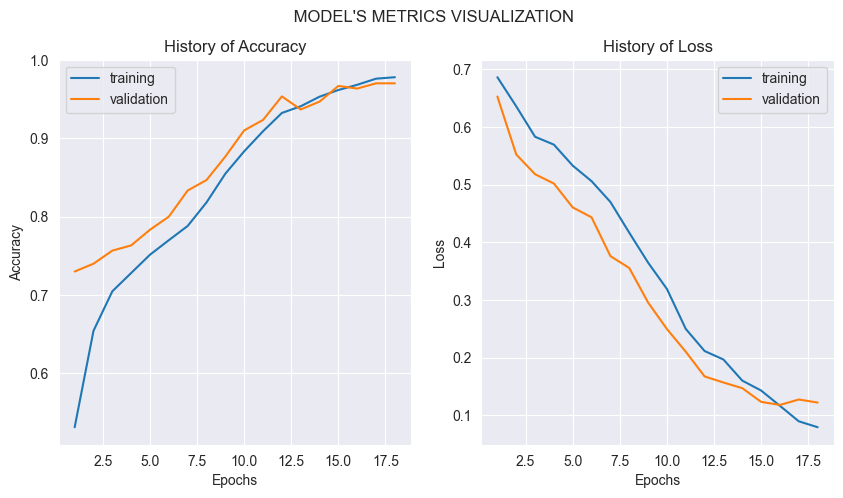

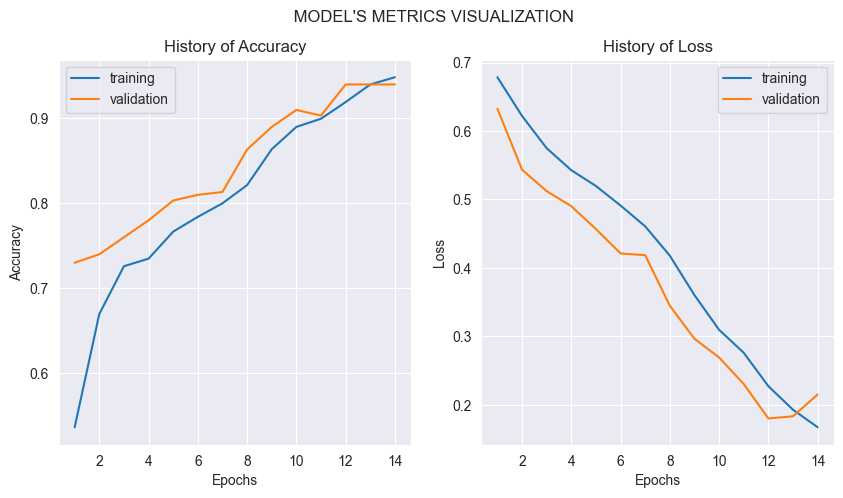

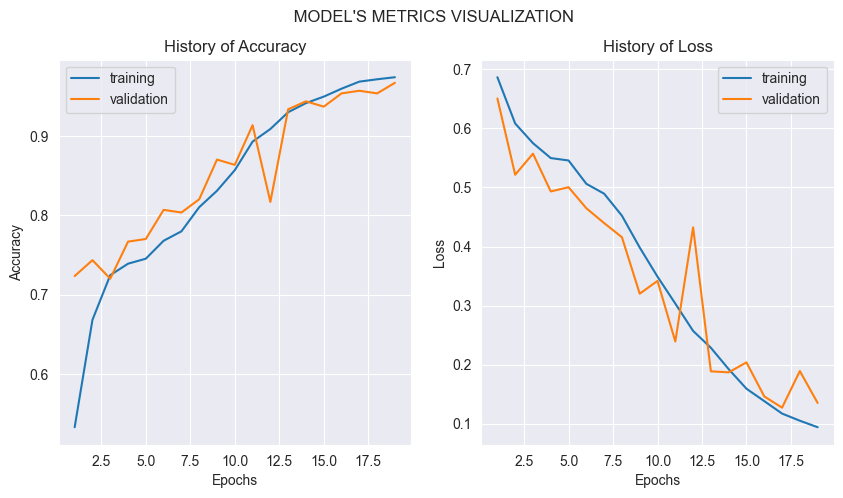

In [8]:
##%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [9]:
##%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = 'C:/vansh/programming/project/python/archive/Br35H-Mask-RCNN/TEST/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)


Found 60 validated image filenames.
6/6 [==============================] - 0s 49ms/step
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0]


In [10]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected']


In [11]:
##%% OBTAINING PREDICTIONS OF THE FIRST BATCH
    
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

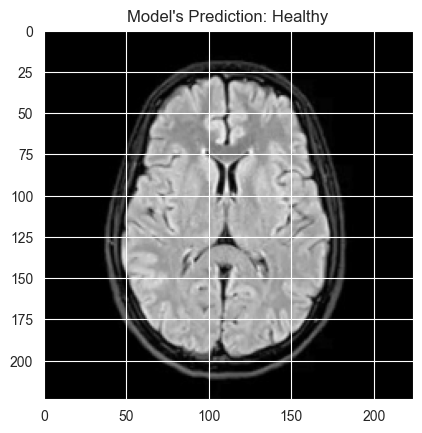

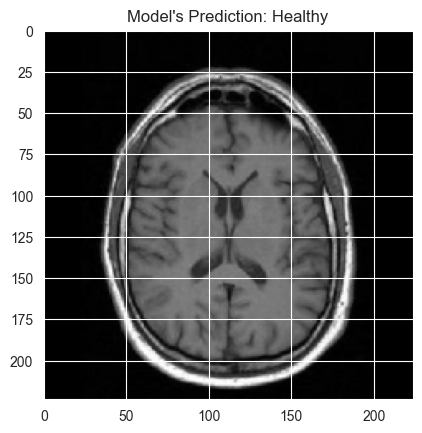

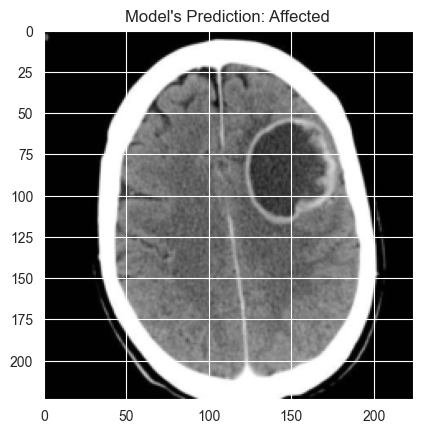

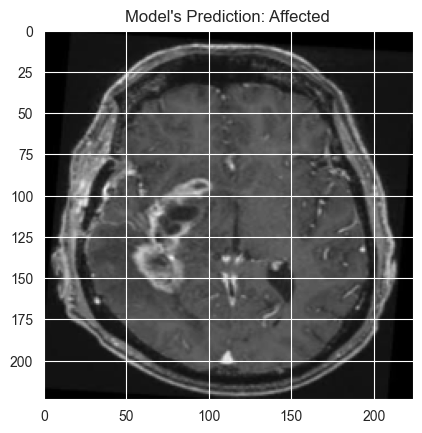

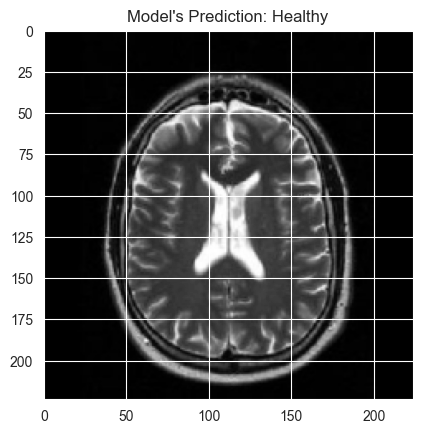

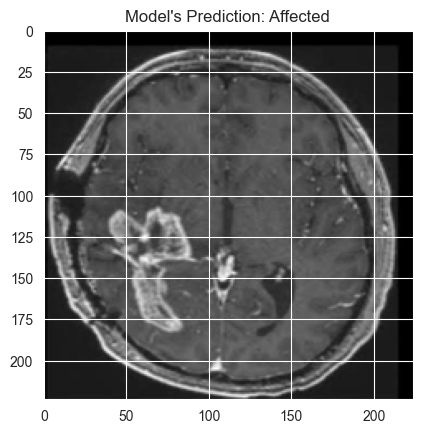

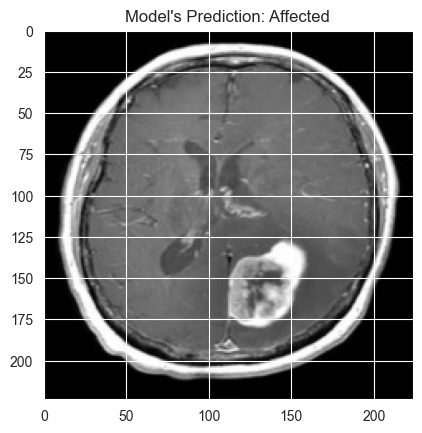

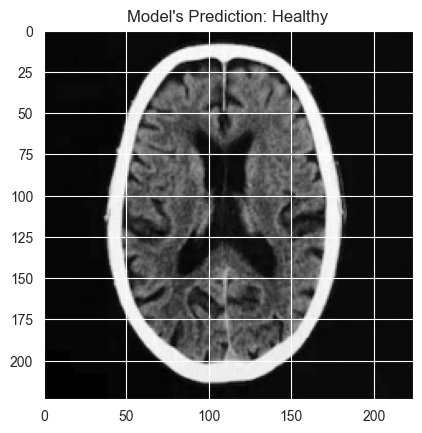

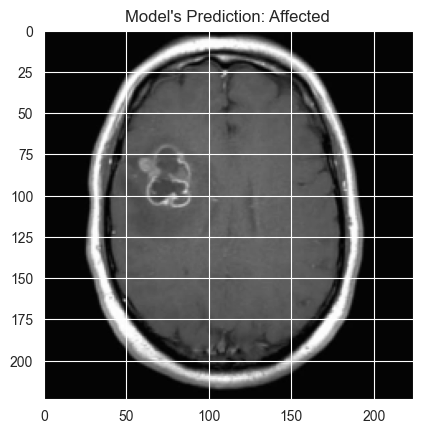

In [12]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)

In [13]:
keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen1 = ImageDataGenerator(rescale = 1./255)

xyz_set = datagen1.flow_from_dataframe(xyz_test,
                                       directory = 'C:/vansh/programming/project/python/archive/Br35H-Mask-RCNN/xyz/y1.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions1 = keras_model.predict(xyz_set)
predictions1 = predictions1.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions1)

Found 1 validated image filenames.
1/1 [==============================] - 0s 232ms/step
Where 0 = 'Affected'
Where 1 = 'Healthy'
[0]


In [14]:
pred1 = []
[pred1.append('Healthy') if i == 1 else pred1.append('Affected') for i in predictions1]
print(pred1)

['Affected']


In [15]:
images_xyz = [xyz_set[0][0]]
            
prediction_xyz = pred1[0:9]
final_xyz_pred = zip(images_xyz,prediction_xyz)

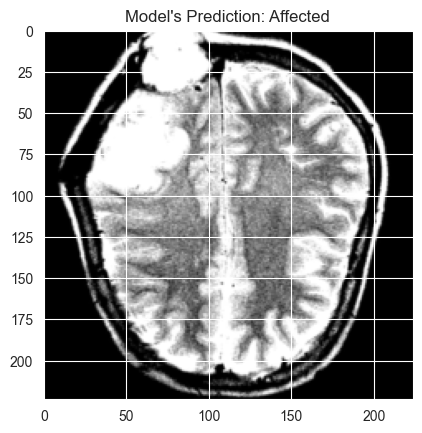

In [16]:
def pre_visualization(data, predictions1):
    
    for image,pred in final_xyz_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images_xyz,prediction_xyz)

<a id="section-two"></a>
### CAM - VISUALIZATION 

In [17]:
##%% IMPORTING LIBRARIES

import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image

Code adapted from: https://keras.io/examples/vision/grad_cam/

In [18]:
layer_names = [layer.name for layer in keras_model.layers]
layer_names

['conv2d_12',
 'max_pooling2d_6',
 'conv2d_13',
 'conv2d_14',
 'conv2d_15',
 'max_pooling2d_7',
 'global_average_pooling2d_3',
 'flatten_3',
 'dense_9',
 'dropout_6',
 'dense_10',
 'dropout_7',
 'dense_11']

In [19]:
##%% CREATING THE HEATMAP FROM THE LAYERS' ACTIVATIONS

img_size = (224, 224)
layer_names=[layer.name for layer in keras_model.layers]

last_conv_layer_name = 'conv2d_15'
classifier_layer_names = [
 'max_pooling2d_7',
 'global_average_pooling2d_3',
 'flatten_3',
 'dense_9',
 'dropout_6',
 'dense_10',
 'dropout_7',
 'dense_11']

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    
    img_array = test_set[0][8]
    img_array = img_array.reshape(1,224,224,1)
    img_array = img_array[:1]
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1,2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


In [20]:
##%% DEFINING A FUNCTION TO DISPLAY THE HEATMAP ON THE REAL IMAGE

def display(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.005 + img.reshape(224,224,1)  # img_array.reshape(224,224,1)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

C:\Users\vansh\AppData\Local\Temp\ipykernel_5632\3301902833.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


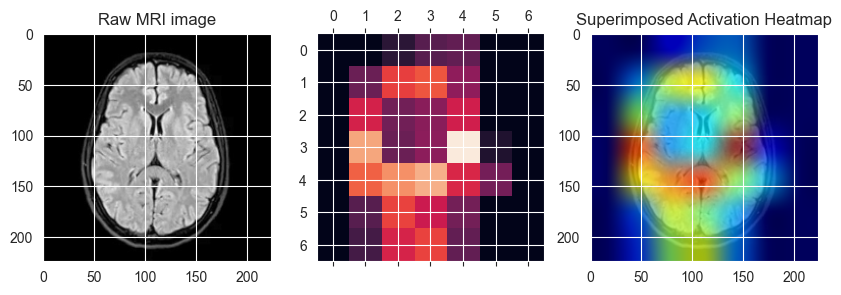

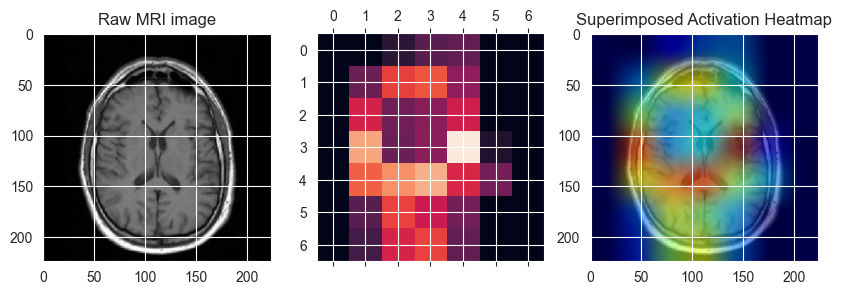

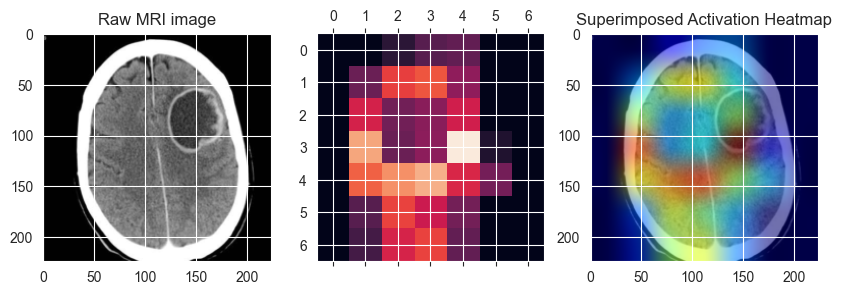

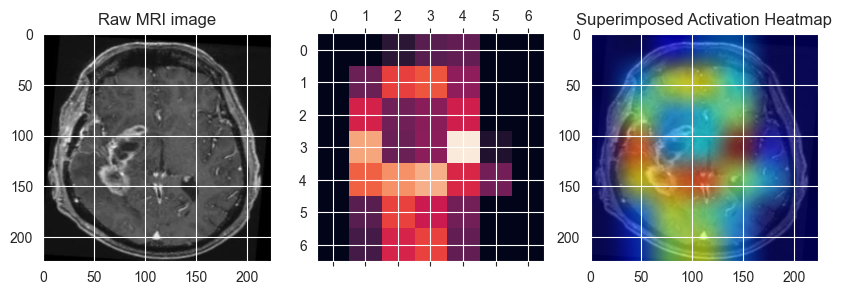

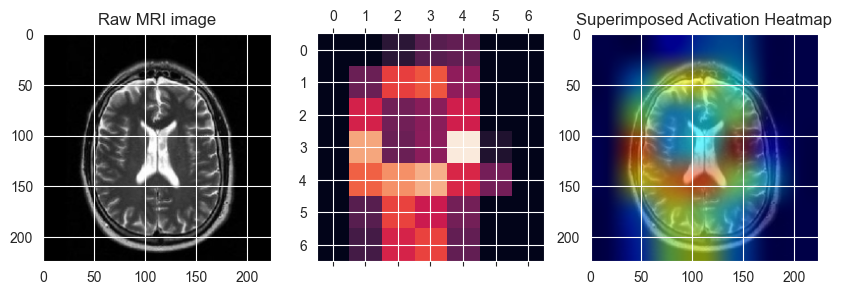

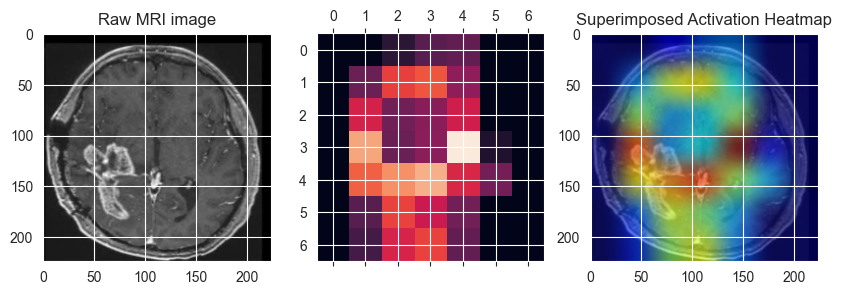

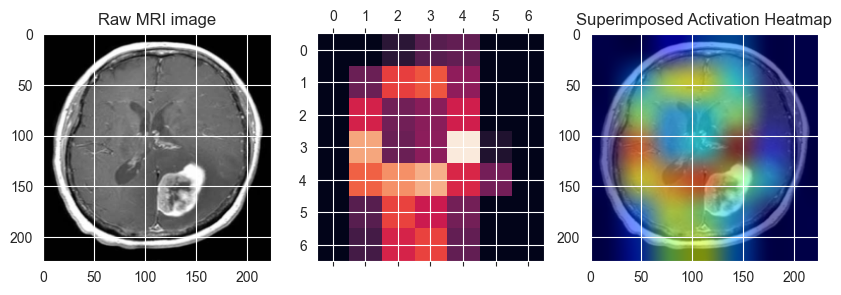

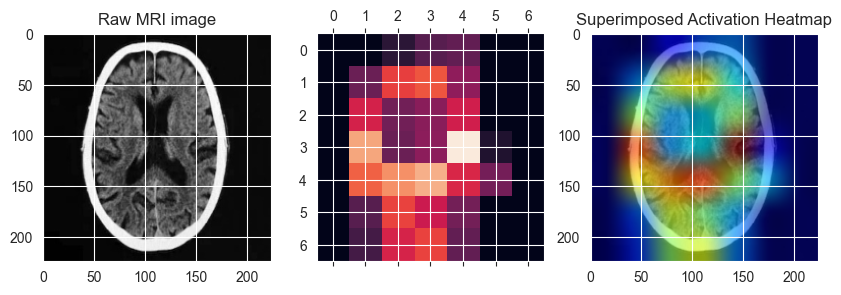

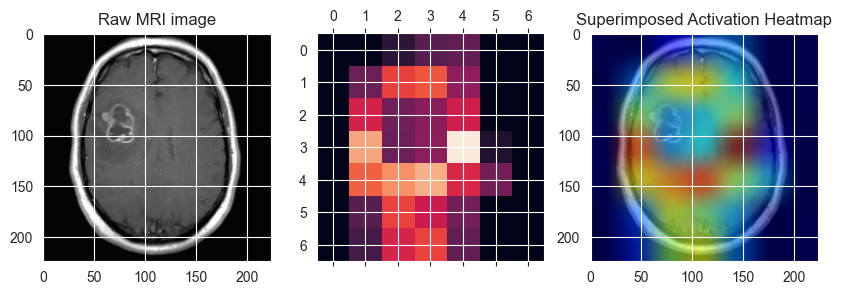

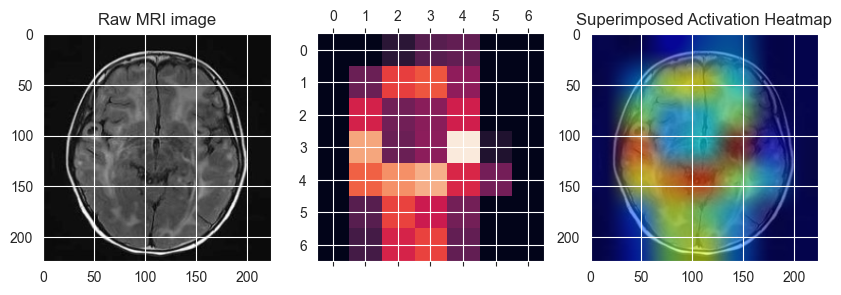

In [21]:
##%% OBSERVING THE RAW IMAGE, THE HEATMAP AND THE SUPERIMPOSED IMAGES TOGETHER

for img in images10:
    heatmap = make_gradcam_heatmap(img,
                                   keras_model,
                                   last_conv_layer_name,
                                   classifier_layer_names)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (10,5))
    
    ax1.imshow(img.reshape(224,224), cmap = 'gray')
    ax1.set_title('Raw MRI image')
    ax2.matshow(heatmap)
    ax3.imshow(display(heatmap,img))
    ax3.set_title('Superimposed Activation Heatmap')

C:\Users\vansh\AppData\Local\Temp\ipykernel_5632\3301902833.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


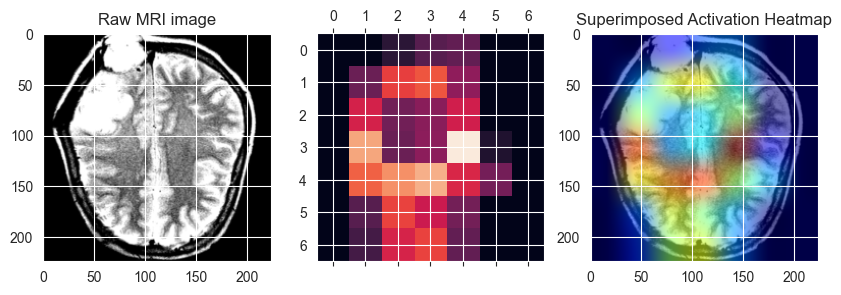

In [22]:

for img in images_xyz:
    heatmap = make_gradcam_heatmap(img,
                                   keras_model,
                                   last_conv_layer_name,
                                   classifier_layer_names)
    fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize= (10,5))
    
    ax4.imshow(img.reshape(224,224), cmap = 'gray')
    ax4.set_title('Raw MRI image')
    ax5.matshow(heatmap)
    ax6.imshow(display(heatmap,img))
    ax6.set_title('Superimposed Activation Heatmap')